<a href="https://colab.research.google.com/github/iciromaco/Semi3A/blob/master/NintendoARCards.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nintendo の ARCardの画像データの生成

任天堂の公開されているARカードのデータを実験用に画像データ化するプログラム

# pdf2image と poppler のインストール

In [1]:
!pip install pdf2image
!apt install poppler-utils poppler-data

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
Suggested packages:
  ghostscript fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  poppler-data poppler-utils
0 upgraded, 2 newly installed, 0 to remove and 43 not upgraded.
Need to get 1,633 kB of archives.
After this operation, 13.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 poppler-data all 0.4.8-2 [1,479 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 poppler-utils amd64 0.62.0-2ubuntu2.10 [154 kB]
Fetched 1,633 kB in 1s (1,515 kB/s)
Selecting previously unselected package poppler-data.
(Reading database ... 144328 files and directories cur

In [0]:
import os
from pdf2image import convert_from_path
import numpy as np
import urllib.request
import cv2
from google.colab.patches import cv2_imshow
fname = "arcard"
pdfname = fname+".pdf"
url = 'https://www.nintendo.co.jp/support/3ds/pdf/3ds_arcard.pdf?_ga=2.223029147.1069627371.1591664344-847263550.1591664344'
urllib.request.urlretrieve(url, pdfname)

DPI = 100

images = convert_from_path(pdfname,dpi=DPI)
images[0].save(fname+".png", "png")
# images[0] 画像の確認がしたければ、コメントを外す

# ２階調化

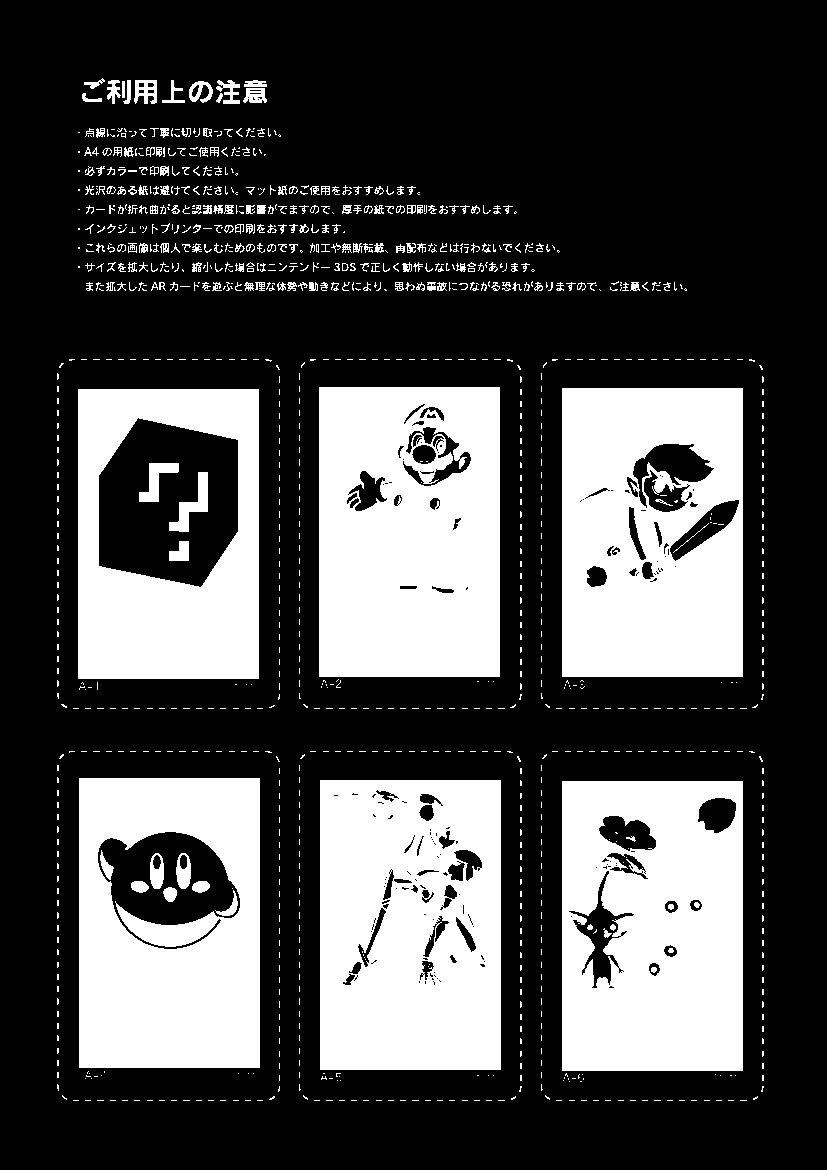

In [3]:
img = np.array(images[0])[:,:,::-1]# OpenCV 形式に変換
gry = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret,bw = cv2.threshold(gry,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
cv2_imshow(bw)

# 収縮膨張でノイズ除去

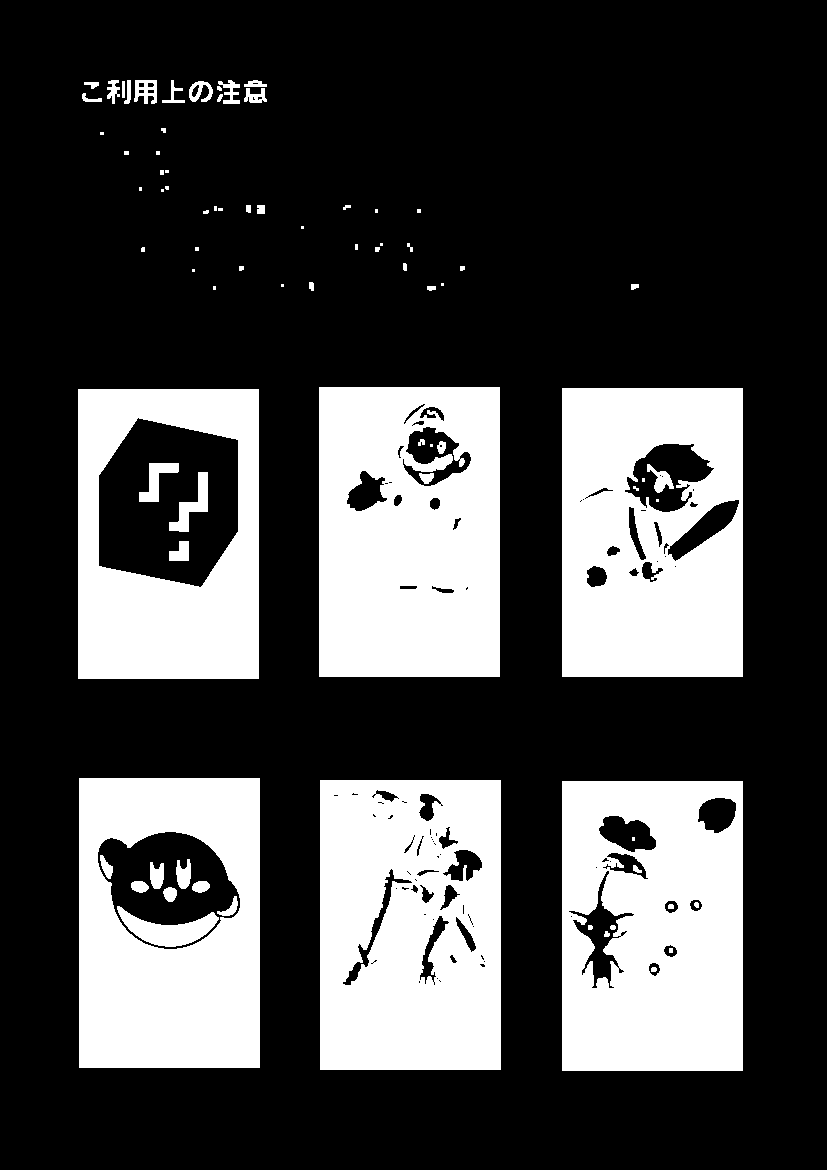

In [4]:
# noise removal
kernel = np.ones((3,3),np.uint8)
bw = cv2.morphologyEx(bw,cv2.MORPH_OPEN,kernel, iterations = 1)
cv2_imshow(bw)

In [0]:
# ラベリング処理
nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(bw)

- nlables はラベル数＝領域数（背景分の１を含む）  
- labels は　各画素の画素値としてラベル番号が割り当てられた画像  
- stats は各ラベルの矩形領域の左上の座標と幅、高さ、面積のデータ　　　　
- centroids は各連結成分の重心位置

In [6]:
stats

array([[     0,      0,    827,   1170, 693879],
       [   107,     80,     13,     24,    173],
       [   122,     81,      3,     17,     51],
       [   124,     80,      7,     24,    102],
       [   134,     80,     23,     24,    365],
       [   162,     80,     23,     23,    157],
       [   189,     81,     24,     21,    270],
       [   218,     80,     22,     24,    247],
       [   244,     80,     23,      7,    111],
       [    84,     82,     15,      7,     66],
       [   217,     86,      5,      5,     20],
       [   244,     88,     23,     15,    206],
       [    82,     93,     20,      9,     83],
       [   217,     94,      6,      8,     30],
       [   161,    128,      5,      5,     21],
       [   100,    132,      4,      3,     12],
       [   124,    151,      5,      4,     20],
       [   156,    151,      4,      4,     16],
       [   160,    170,      4,      5,     20],
       [   165,    170,      4,      3,     12],
       [   139,    1

In [7]:
areas = stats[:,4] # 面積のデータのみ抜き出す
areas

array([693879,    173,     51,    102,    365,    157,    270,    247,
          111,     66,     20,    206,     83,     30,     21,     12,
           20,     16,     20,     12,     12,     15,      9,     38,
           70,     26,     15,     15,     12,     16,     20,      9,
            9,     27,     18,     19,     16,     23,     30,     23,
           23,      9,     40,      9,      9,     40,     12,     39,
        48944,  33384,  45961,     35,     85,      9,    689,    335,
          881,    116,     12,     18,      9,    300,  40527,  49037,
        47223,     12,    167,    323,    295,     44,    166,    167,
          160,    164,     25,     28,   1886,     23,     26,     28,
           20,     27], dtype=int32)

In [8]:
# 面積の大きい順にインデックスを並べる
sareas  = np.argsort(areas)[::-1]
sareas

array([ 0, 63, 48, 64, 50, 62, 49, 76, 56, 54,  4, 55, 67, 61, 68,  6,  7,
       11,  1, 66, 71, 70, 73, 72,  5, 57,  8,  3, 52, 12, 24,  9,  2, 69,
       42, 45, 47, 23, 51, 13, 38, 79, 75, 33, 81, 25, 78, 74, 40, 37, 77,
       39, 14, 10, 16, 80, 18, 30, 35, 34, 59, 36, 29, 17, 27, 26, 21, 15,
       28, 19, 20, 46, 58, 65, 41, 44, 53, 60, 31, 32, 22, 43])

In [0]:
# カードの白領域のインデックス
cardareas = sareas[1:7]

In [10]:
cardimgs = [None]*6
for i in range(6):
  x1,y1,w,h = stats[cardareas[i]][:4]
  cardimgs[i] = img[y1:y1+h,x1:x1+w,:]
  print(cardimgs[i].shape)

(290, 181, 3)
(290, 181, 3)
(290, 181, 3)
(289, 181, 3)
(290, 181, 3)
(290, 181, 3)


# 大きさを統一して出力

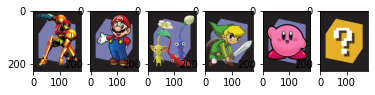

In [11]:
import matplotlib.pyplot as plt
h = int(cardimgs[0].shape[0]*0.783)
# Nintendo マークを特徴抽出対象から外すために、高さを 0.783 倍でカット
arcards = [None]*6
for i in range(6):
    arcards[i]=cardimgs[i][0:h,:,:]
    cv2.imwrite("ar"+str(i)+".png",arcards[i])
    plt.subplot(1,6,i+1)
    plt.imshow(arcards[i][:,:,::-1])

# Zipアーカイブの作成
ひとつずつダウンロードするのは面倒なので、zipファイル一つにまとめる

In [0]:
import zipfile
with zipfile.ZipFile('ar.zip','w') as myzip:
    for i in range(6):
      fn = "ar"+str(i)+".png"
      myzip.write(fn,fn)